In [ ]:
# ===============================================
# Video Stutter Detection Notebook
# このノートブックは動画のカクつき（stutter）を検出・解析するための最終段階のコード
# 実行環境（カーネル）はTestProg_video（Python 3.8.19）で行ってください
#
# ■メモ
# 改善確が終わったら、バージョンアップする。
#
# v0.0.1での対応
# イニシャル
# 各動作に説明を追記
# ===============================================

In [5]:
# ==========================================================
# 必要なライブラリのインポート（重複除去・カテゴリ別整理）
# ==========================================================

# --- 画像処理・数値計算 ---
import cv2                   # OpenCV: 動画読み込み・画像処理用
import numpy as np            # NumPy: 数値計算・配列処理用

# --- 可視化 ---
import matplotlib.pyplot as plt  # グラフ描画・可視化用

# --- GUI ---
import tkinter as tk             # GUI用
from tkinter import ttk          # GUI用（拡張ウィジェット）

# --- ファイル・システム操作 ---
import os                        # ファイルパス操作・環境操作
import shutil                    # ファイルコピー・削除

# --- 並行処理 ---
import threading                 # マルチスレッド処理
import queue                     # スレッド間通信・キュー処理

# --- その他ユーティリティ ---
import time                      # 時間計測・待機
import gc                        # ガーベジコレクション操作
import re                        # 正規表現処理
import sys                       # システム関連（パス・終了処理など）

In [6]:
# -----------------------------------------------
# list_video_devices 関数 (利用可能ビデオキャプチャデバイス一覧取得関数)
# -----------------------------------------------
"""
概要:
    接続されているビデオキャプチャデバイス（Webカメラなど）を探索し、
    利用可能なデバイス番号と識別名のリストを返す関数。
    この関数を使用することで、ユーザーが利用可能なカメラデバイスを選択可能になる。
    
引数:
    max_devices (int, optional): チェックする最大デバイス番号。デフォルトは10。
    timeout (float, optional): 各デバイスを試す際のタイムアウト秒数。デフォルトは1.0秒。
    
戻り値:
    devices (list of tuples): 利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]
        
注意:
    - デバイスマネージャーで Trifora など特定ドライバを使用している場合、
      一部デバイスが正常に認識されないことがあります。
    - cv2.VideoCapture() は番号順にデバイスを開くため、
      接続順序によってデバイス番号が変わることがあります。
"""
def list_video_devices(max_devices=10, timeout=1.0):
    devices = []  # 利用可能なデバイスを格納するリスト

    # 内部関数：指定インデックスのデバイスが使用可能かチェック
    def try_open_device(idx, result_dict):
        try:
            # Windows向けに DirectShow 経由でデバイスをオープン
            cap = cv2.VideoCapture(idx, cv2.CAP_DSHOW)

            # 開けたかを確認
            if cap.isOpened():
                result_dict["opened"] = True

            # デバイスを解放（リソースリーク防止）
            cap.release()

        except Exception as e:
            # エラーが発生した場合（存在しない or ドライバエラーなど）
            print(f"デバイス {idx} は無視されました: {e}")
            result_dict["opened"] = False

    # 0 〜 max_devices-1 まで順にデバイスをチェック
    for idx in range(max_devices):
        result = {"opened": False}  # チェック結果を格納する辞書

        # スレッドを生成し、非同期でデバイスをオープンしてみる
        t = threading.Thread(target=try_open_device, args=(idx, result))
        t.start()

        # 指定時間だけスレッドの完了を待機（ハング防止）
        t.join(timeout=timeout)

        if t.is_alive():
            # タイムアウトを超えても応答がない場合
            print(f"デバイス {idx} はタイムアウト ({timeout} 秒) によりスキップされました")
        elif result["opened"]:
            # 正常に開けたデバイスを一覧に追加
            devices.append((idx, f"Camera {idx}"))

    return devices

# -----------------------------------------------
# 実行例（このファイルを直接実行した場合のみ動作）
# -----------------------------------------------
if __name__ == "__main__":
    print("利用可能なビデオキャプチャデバイス:")
    devices = list_video_devices(max_devices=10, timeout=1.0)

    # 検出されたカメラの一覧を出力
    for idx, name in devices:
        print(f"デバイス番号: {idx}, 名前: {name}")


利用可能なビデオキャプチャデバイス:
デバイス番号: 0, 名前: Camera 0
デバイス番号: 1, 名前: Camera 1


In [7]:
# -----------------------------------------------
# launch_gui 関数 (ビデオデバイス選択GUI関数)
# -----------------------------------------------
"""
概要:
    ユーザーが接続されているビデオキャプチャデバイスの中から
    1つを選択できるシンプルなGUIを表示し、
    選択されたデバイス番号を返す関数。

引数:
    devices (list of tuples):
        list_video_devices() などで取得した利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]

戻り値:
    int or None:
        - ユーザーが「開始」ボタンを押した場合 → 選択されたデバイス番号を返す
        - GUIを閉じた、または何も選ばなかった場合 → None を返す

注意:
    - combo.current(0) により、デフォルトで最初のデバイスが選択される。
    - GUIを閉じただけで何も選ばなかった場合は None が返る。
    - tkinter は標準ライブラリのため、追加インストールは不要。
"""
def launch_gui(devices):
    selected_device = {"idx": None}  # 辞書で選択結果を共有（クロージャ内で参照できるようにする）

    # --------------------------------------------
    # GUI ウィンドウの基本設定
    # --------------------------------------------
    root = tk.Tk()                     # メインウィンドウ作成
    root.title("デバイス選択")          # ウィンドウタイトル設定
    root.geometry("300x150")           # ウィンドウサイズ（任意）
    root.resizable(False, False)       # サイズ変更を禁止

    # ラベル表示
    tk.Label(root, text="使用するデバイスを選択:").pack(pady=5)

    # --------------------------------------------
    # コンボボックス（デバイス一覧表示）
    # --------------------------------------------
    # 表示用に "Camera 0 (番号: 0)" のような文字列リストを生成
    display_names = [f"{name} (番号: {idx})" for idx, name in devices]

    device_var = tk.StringVar()  # コンボボックスの選択値を保持する変数

    # ttk.Combobox：選択式のプルダウンリスト
    combo = ttk.Combobox(
        root,
        textvariable=device_var,
        values=display_names,
        state="readonly"  # 編集不可（選択のみ）
    )
    combo.current(0)  # デフォルトで最初の項目を選択
    combo.pack(pady=5)

    # --------------------------------------------
    # 「開始」ボタンの動作定義
    # --------------------------------------------
    """
    「開始」ボタン押下時の処理。
    現在選択されている項目のインデックスからデバイス番号を取得し、
    それを共有辞書 selected_device に格納してウィンドウを閉じる。
    """
    def on_start():
        selected_device["idx"] = devices[combo.current()][0]
        root.destroy()  # GUIを閉じる（mainloopを終了）

    # ボタンの作成と配置
    tk.Button(root, text="開始", command=on_start).pack(pady=10)

    # --------------------------------------------
    # GUI メインループ開始（ここで処理が一時停止し、ユーザー操作を待つ）
    # --------------------------------------------
    root.mainloop()

    # 閉じた後、選択されたデバイス番号を返す（選択なしなら None）
    return selected_device["idx"]

In [8]:
# ====================================================
# 🔒 safe_rmtree 関数（安全で完全なフォルダ削除関数 / Windows対応・再試行付き）
# ====================================================
"""
概要:
    指定したフォルダを安全に削除する関数。
    Windows環境でよく発生する「削除中にファイルロックやアクセス拒否で失敗する」ケースにも対応し、
    一定回数リトライを行いながら、フォルダとその中身を完全に削除する。

引数:
    folder_path (str): 削除対象のフォルダパス。
    retry (int, optional): 削除を再試行する回数。デフォルトは3回。
    wait (float, optional): 再試行の間隔（秒）。デフォルトは0.5秒。

動作:
    - 存在しないフォルダを指定した場合はスキップしてメッセージを表示。
    - フォルダ内の全ファイル・サブフォルダを逆順に削除（os.walk(topdown=False)）。
    - 削除進捗をコンソール上にバー表示（例: [##########----------] 50%）。
    - 削除中にエラーが発生した場合でも処理を継続し、最大 retry 回までリトライ。

戻り値:
    なし（処理結果は標準出力にメッセージとして表示）

注意:
    - 削除対象フォルダは **完全に消去** されるため、取り消しはできません。
    - フォルダが他のプロセスによって使用中の場合、一時的に削除が遅れる場合があります。
    - Windows特有の一時ロックを考慮して wait 秒待機後に再試行を行います。
"""
def safe_rmtree(folder_path: str, retry=3, wait=0.5):
    # -------------------------------
    # 存在チェック
    # -------------------------------
    if not os.path.exists(folder_path):
        print(f"🗑️ フォルダ不存在: {folder_path}")
        return

    # -------------------------------
    # 内部関数: フォルダ内の全要素を取得（下位から上位へ削除するため）
    # -------------------------------
    def get_all_entries(path):
        entries = []
        # topdown=False により、ファイル → サブフォルダ → 親フォルダ の順に削除可能
        for root, dirs, files in os.walk(path, topdown=False):
            # ファイルを追加
            entries.extend([os.path.join(root, f) for f in files])
            # ディレクトリを追加
            entries.extend([os.path.join(root, d) for d in dirs])
        return entries

    # -------------------------------
    # 削除処理本体
    # -------------------------------
    for attempt in range(retry):
        try:
            all_entries = get_all_entries(folder_path)
            total = len(all_entries)

            # サブフォルダ・ファイルが空ならフォルダ自体を削除
            if total == 0:
                os.rmdir(folder_path)
                print(f"🗑️ 完全削除済み: {folder_path}")
                return

            # 削除ループ（進捗付き）
            for i, entry in enumerate(all_entries, start=1):
                try:
                    if os.path.isfile(entry) or os.path.islink(entry):
                        os.remove(entry)  # ファイル or シンボリックリンク削除
                    elif os.path.isdir(entry):
                        os.rmdir(entry)   # 空フォルダ削除
                except Exception as e:
                    print(f"⚠ 削除失敗: {entry} → {e}")

                # ----------------------------------------
                # 進捗バー表示
                # ----------------------------------------
                pct = int(i / total * 100)
                bar_len = 30  # バーの長さ（文字数）
                filled = int(bar_len * pct / 100)
                sys.stdout.write(f"\r削除中: [{'#'*filled}{'-'*(bar_len-filled)}] {pct}%")
                sys.stdout.flush()

            # ----------------------------------------
            # 最後にフォルダ自体を削除
            # ----------------------------------------
            try:
                os.rmdir(folder_path)
            except Exception as e:
                print(f"\n⚠ フォルダ自体の削除失敗: {e}")
            else:
                print(f"\n🗑️ 完全削除済み: {folder_path}")
            break  # 成功したらループを抜ける

        except Exception as e:
            print(f"\n⚠ 削除中エラー: {e} → {wait}秒後に再試行 ({attempt+1}/{retry})")
            time.sleep(wait)
    else:
        # retry 回すべて失敗した場合
        print(f"❌ {folder_path} の削除に失敗しました。")


In [9]:
# ====================================================
# stutter_worker_first_only 関数（カクつき検知ワーカー（最初のフレームのみ保存））
# ====================================================
"""
概要:
    映像の「カクつき（動きの停止）」を検知し、その区間の最初のフレームのみを保存するスレッドワーカー。
    フレームキューを継続的に監視し、隣接フレーム間の差分が一定以下の状態が一定時間続いた場合、
    それを「カクつき」と判断し、最初のフレームを保存する。
    これにより、映像ストリーム中の停止現象やフリーズを自動検出・記録できる。

引数:
    frame_queue (queue.Queue):
        メインスレッドなどから供給されるフレーム情報を保持するキュー。
        各要素は (idx, frame) の形式で、フレーム番号と画像データを含む。
    
    output_folder (str):
        検出されたカクつき区間の最初のフレームを保存するフォルダのパス。
        存在しない場合は自動的に作成される。
    
    stop_flag (threading.Event):
        外部からスレッド停止を指示するフラグ。
        set() が呼ばれると処理を安全に終了する。

    fps (float, optional):
        フレームレート（1秒あたりのフレーム数）。デフォルトは60。
        カクつき検出時の時間換算などに使用する。
    
    threshold (int, optional):
        フレーム間の差分画素数がこの値以下のとき「変化なし」とみなす閾値。
        小さいほど感度が高くなる（=わずかな動きでも変化と判断）。
    
    min_time_diff (float, optional):
        カクつきとみなすために必要な最小の「変化なし」時間（秒）。
        fps と掛け合わせて最小フレーム数を算出する。
    
    stop_no_diff_sec (float, optional):
        一定時間以上まったく変化がない場合、キャプチャが停止したと判断し自動終了する。
        デフォルトは300秒（=5分）。

動作仕様:
    1. キューからフレームを順次取得し、グレースケールに変換。
    2. 前フレームとの差分を計算し、変化が少ない場合は一時バッファに追加。
    3. 差分が一定以上になった時点で「変化再開」と判断し、
       溜まっていた静止区間の最初のフレームを保存。
    4. 5分以上変化がない場合は自動停止。
    5. 終了時（例外含む）にはバッファ内の未保存フレームも保存。

戻り値:
    なし（結果は output_folder 内に画像ファイルとして保存される）

保存ファイル形式:
    stutter_00001.png, stutter_00002.png, ... のように連番で保存される。

注意:
    - メモリ消費を抑えるため、古いフレームは随時削除・ガベージコレクトされる。
    - stop_flag が set() されると即座に処理を終了する。
    - 処理中に cv2.destroyAllWindows() が呼ばれるため、同時にGUIウィンドウを扱う場合は注意。
"""
def stutter_worker_first_only(frame_queue, output_folder, stop_flag,
                              fps=60, threshold=100, min_time_diff=0.1, stop_no_diff_sec=300):
    # ---- 設定パラメータの初期化 ----
    min_frame_diff = int(min_time_diff * fps)  # カクつきとみなす最小フレーム数
    prev_gray = None                          # 前回フレーム（グレースケール）
    temp_stutter_indices = []                 # 一時的に「動きが少ない」フレームを保持
    stutter_frames = []                       # 検出したカクつき区間の最初のフレーム番号を記録
    last_diff_time = time.time()              # 最後に変化があった時刻を記録

    # 保存先フォルダを作成（なければ作る）
    os.makedirs(output_folder, exist_ok=True)

    try:
        # stop_flag が立つまでループ（メインスレッドから停止指示が来るまで動作）
        while not stop_flag.is_set():
            try:
                # キューから1フレーム取得（1秒待っても来なければ再試行）
                item = frame_queue.get(timeout=1)
            except queue.Empty:
                continue  # フレームが来ない場合はスキップしてループ継続

            # None が来たら終了指示
            if item is None:
                frame_queue.task_done()
                break

            idx, frame = item  # フレーム番号と画像データを展開
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # グレースケール化して差分計算しやすくする

            # --- 前回フレームと比較して差分を取る ---
            if prev_gray is not None:
                diff = cv2.absdiff(gray, prev_gray)              # 画素ごとの差分（絶対値）
                non_zero_count = np.count_nonzero(diff)          # 動いている画素数をカウント

                if non_zero_count <= threshold:
                    # 動きがほとんど無い → 一時バッファに追加
                    temp_stutter_indices.append((idx, frame))

                    # バッファが大きくなりすぎないように古いものを削除
                    if len(temp_stutter_indices) > min_frame_diff * 3:
                        temp_stutter_indices.pop(0)
                else:
                    # 動きが再開した場合（差分がしきい値を超えた）
                    if len(temp_stutter_indices) >= min_frame_diff:
                        # 動きがなかった期間の最初のフレームを保存
                        first_idx, first_frame = temp_stutter_indices[0]
                        stutter_frames.append(first_idx)
                        cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:05d}.png"), first_frame)

                    # 一時バッファをリセットして新しい動きに備える
                    temp_stutter_indices = []
                    last_diff_time = time.time()  # 最終変化時刻を更新

            prev_gray = gray  # 今回のフレームを次回の比較用として保存

            # --- 一定時間まったく変化がなければ自動停止 ---
            if time.time() - last_diff_time > stop_no_diff_sec:
                print("⚠ 5分以上変化なし：キャプチャ停止（ワーカー）")
                stop_flag.set()
                cv2.destroyAllWindows()
                break

            # キューのタスクを完了としてマーク
            frame_queue.task_done()

            # メモリ解放（明示的に削除してガベージコレクトを促す）
            del frame, gray

            # 動きがなく長時間経過したとき、バッファを整理してメモリを節約
            if len(temp_stutter_indices) > 0 and (time.time() - last_diff_time) > 5:
                temp_stutter_indices = temp_stutter_indices[-min_frame_diff:]
                gc.collect()

    finally:
        # --- 終了処理（例外含む） ---
        # まだ保存されていない静止フレームが残っていれば最後に保存
        if len(temp_stutter_indices) >= min_frame_diff:
            first_idx, first_frame = temp_stutter_indices[0]
            stutter_frames.append(first_idx)
            cv2.imwrite(os.path.join(output_folder, f"stutter_{first_idx:05d}.png"), first_frame)

        # 結果を出力
        print(f"✅ カクつき検出終了: {len(stutter_frames)} フレーム保存完了")

        # 明示的にガベージコレクトを実行してメモリを開放
        gc.collect()


In [10]:
# ====================================================
# detect_stutter_auto_threshold 関数（自動閾値による全フレームカクつき検出）
# ====================================================
"""
概要:
    指定フォルダ内の全フレーム画像（png）を対象に、動きの差分に基づいて
    「カクつき（動きの少ないフレーム）」を自動検出する関数。
    差分の統計量から自動的に閾値を決定し、閾値以下のフレームをカクつきとして扱う。
    カクつきフレームとその前後1フレームを output_folder にコピーして保存する。

引数:
    temp_folder (str):
        処理対象の一時フレームが保存されているフォルダ。
        フレームは png 形式であることを前提。
    
    fps (float, optional):
        1秒あたりのフレーム数。カクつき判定の最小フレーム数計算に使用。デフォルトは60。
    
    min_time_diff (float, optional):
        カクつきとみなす最小連続時間（秒）。デフォルトは0.1秒。
    
    output_folder (str, optional):
        検出されたカクつきフレームを保存するフォルダ。
        指定がない場合はデスクトップに "stutter_frames" フォルダを作成。
    
    threshold_method (str, optional):
        差分閾値の計算方法。'std' または 'median' を指定可能。デフォルトは 'std'。
    
    k (float, optional):
        閾値計算時の標準偏差の倍率。デフォルトは2.0。

戻り値:
    stutter_frames (list):
        カクつきとして検出されたフレーム番号のリスト。

動作:
    1. 出力フォルダを空にして作成。
    2. フレームファイルを読み込み、隣接フレーム間の差分を計算。
    3. 差分配列の平均・中央値と標準偏差から自動的に閾値を算出。
    4. 各フレームの差分と閾値を比較し、閾値以下が min_frame_diff 以上連続する場合カクつきと判定。
    5. 検出されたカクつきフレームとその前後1フレームを出力フォルダにコピー。
"""
def detect_stutter_auto_threshold(temp_folder, fps=60, min_time_diff=0.1, output_folder=None, threshold_method='std', k=2.0):
    # 出力フォルダが指定されていなければデスクトップに作成
    if output_folder is None:
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        output_folder = os.path.join(desktop, "stutter_frames")

    # 古いフォルダを削除して空にする
    safe_rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)
    print(f"{output_folder} を空の状態で作成しました。")

    # フレームファイル一覧を取得してソート
    frame_files = sorted([f for f in os.listdir(temp_folder) if f.endswith('.png')])
    if not frame_files:
        print("フレームが見つかりません。")
        return []

    stutter_frames = []            # 検出したカクつきフレーム番号を格納
    temp_stutter_indices = []      # 一時的に連続する閾値以下フレームを保持
    min_frame_diff = int(min_time_diff * fps)  # カクつき判定に必要な最小フレーム数

    # --- 差分計算用に最初のフレームを読み込み ---
    prev_frame = cv2.imread(os.path.join(temp_folder, frame_files[0]), cv2.IMREAD_GRAYSCALE)
    diff_values = []

    # 隣接フレーム間の差分を配列に保存
    for fname in frame_files[1:]:
        curr_frame = cv2.imread(os.path.join(temp_folder, fname), cv2.IMREAD_GRAYSCALE)
        diff_values.append(np.count_nonzero(cv2.absdiff(curr_frame, prev_frame)))  # 非ゼロ画素数＝変化量
        prev_frame = curr_frame
        del curr_frame

    diff_array = np.array(diff_values)

    # --- 閾値の自動計算 ---
    if threshold_method == 'std':
        threshold = np.mean(diff_array) - k * np.std(diff_array)
    elif threshold_method == 'median':
        threshold = np.median(diff_array) - k * np.std(diff_array)
    else:
        raise ValueError("threshold_method は 'std' か 'median' を指定してください。")
    threshold = max(threshold, 0)
    print(f"自動計算された差分しきい値: {threshold:.2f}")

    # --- 差分を用いたカクつき判定 ---
    prev_frame = cv2.imread(os.path.join(temp_folder, frame_files[0]), cv2.IMREAD_GRAYSCALE)
    for i, fname in enumerate(frame_files[1:], start=1):
        curr_frame = cv2.imread(os.path.join(temp_folder, fname), cv2.IMREAD_GRAYSCALE)
        non_zero_count = np.count_nonzero(cv2.absdiff(curr_frame, prev_frame))  # 差分計算

        if non_zero_count <= threshold:
            # 閾値以下なら一時バッファに追加
            temp_stutter_indices.append(i)
        else:
            # 閾値以上 → 変化が再開
            if len(temp_stutter_indices) >= min_frame_diff:
                # 一定フレーム以上連続している場合、カクつきとして記録
                stutter_frames.extend(temp_stutter_indices)
                # 検出フレームと前後1フレームをコピー
                for idx in temp_stutter_indices:
                    save_indices = [max(idx-1,0), idx, min(idx+1,len(frame_files)-1)]
                    for sidx in save_indices:
                        src = os.path.join(temp_folder, frame_files[sidx])
                        dst = os.path.join(output_folder, f"stutter_{frame_files[sidx]}")
                        shutil.copy(src, dst)
            temp_stutter_indices = []  # バッファをリセット

        prev_frame = curr_frame
        del curr_frame

    # --- 最後に残ったバッファも保存 ---
    if len(temp_stutter_indices) >= min_frame_diff:
        stutter_frames.extend(temp_stutter_indices)
        for idx in temp_stutter_indices:
            save_indices = [max(idx-1,0), idx, min(idx+1,len(frame_files)-1)]
            for sidx in save_indices:
                src = os.path.join(temp_folder, frame_files[sidx])
                dst = os.path.join(output_folder, f"stutter_{frame_files[sidx]}")
                shutil.copy(src, dst)

    print(f"{len(stutter_frames)} フレームがカクつきとして検出され、前後も含めて {output_folder} に保存されました。")
    return stutter_frames


In [11]:
# ====================================================
# start_capture_and_detect 関数（キャプチャ＆逐次カクつき検知）
# 修正が必要→逐次カクつき検知（リアルタイム）とキャプチャ終了後の全フレーム解析の2回行われていることを修正
# ====================================================
"""
概要:
    指定したビデオキャプチャデバイスから映像を取得し、
    リアルタイムで逐次カクつき検知を行う完全版関数。
    - 一時フォルダにフレームを保存
    - スレッドでカクつきワーカーを動作
    - 画面表示は FPS 制限付きでプレビュー
    - ユーザー操作や停止フラグで安全に終了
    - キャプチャ終了後、自動閾値で全フレームを解析してカクつきフレームを抽出

引数:
    device_number (int, optional):
        使用するカメラのデバイス番号。デフォルトは0。
    
    width, height (int, optional):
        キャプチャ解像度。デフォルトは 720x480。
    
    capture_fps (float, optional):
        キャプチャするフレームレート。デフォルトは60。
    
    display_fps (float, optional):
        プレビュー表示用 FPS。デフォルトは10。
    
    threshold (int, optional):
        カクつき判定用の差分閾値。逐次検知に使用。
    
    min_time_diff (float, optional):
        カクつきとみなす最小連続時間（秒）。
    
    max_temp_frames (int, optional):
        一時フォルダに保存する最大フレーム数。超えた場合はフォルダをクリア。
    
    stop_no_diff_sec (float, optional):
        一定時間変化がなければ自動停止する秒数。
    
    threshold_method (str, optional):
        自動閾値算出時の方法 ('std' or 'median')。
    
    k (float, optional):
        自動閾値算出時の標準偏差倍率。

戻り値:
    frame_count (int):
        実際にキャプチャしたフレーム数
    output_folder (str):
        カクつきフレームが保存されたフォルダ
    actual_fps (float):
        キャプチャ中の実測 FPS
    stutter_frames (list):
        自動閾値で検出されたカクつきフレーム番号リスト
"""
def start_capture_and_detect(device_number=0, width=720, height=480,
                             capture_fps=60, display_fps=10, threshold=100,
                             min_time_diff=0.1, max_temp_frames=36000, stop_no_diff_sec=300,
                             threshold_method='std', k=2.0):

    # デスクトップに一時フォルダと出力フォルダを作成
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    temp_folder = os.path.join(desktop, "temp_frames")
    output_folder = os.path.join(desktop, "stutter_frames")

    for folder in (temp_folder, output_folder):
        safe_rmtree(folder)  # 古いフォルダを削除
        os.makedirs(folder, exist_ok=True)
    print(f"📁 {temp_folder} と {output_folder} を作成しました。")

    # カメラを開く
    cap = cv2.VideoCapture(device_number, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("❌ Error: キャプチャデバイスを開けませんでした。")
        return 0, output_folder, 0

    # キャプチャ設定
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    cap.set(cv2.CAP_PROP_FPS, capture_fps)

    # スレッド停止用フラグとフレームキューを作成
    stop_flag = threading.Event()
    frame_queue = queue.Queue(maxsize=5)

    # カクつき検知ワーカーをバックグラウンドで起動
    worker = threading.Thread(
        target=stutter_worker_first_only,
        args=(frame_queue, output_folder, stop_flag, capture_fps, threshold, min_time_diff, stop_no_diff_sec),
        daemon=True
    )
    worker.start()

    frame_count = 0
    display_interval = 1.0 / display_fps
    prev_display_time = time.time()
    start_time = time.time()

    print("🎥 映像キャプチャ開始。'q'キーで終了できます。")

    try:
        while cap.isOpened():
            # 停止フラグ検知でループ終了
            if stop_flag.is_set():
                print("🛑 停止フラグ検知：メインループ終了")
                break

            # フレーム取得
            ret, frame = cap.read()
            if not ret:
                print("⚠ フレーム取得失敗、停止します。")
                break

            # 一時フォルダにフレーム保存
            frame_file = os.path.join(temp_folder, f"frame_{frame_count:05d}.png")
            cv2.imwrite(frame_file, frame)

            # ワーカー用キューに送信（Fullならスキップ）
            try:
                frame_queue.put_nowait((frame_count, frame.copy()))
            except queue.Full:
                pass

            # FPS制御付きプレビュー表示
            curr_time = time.time()
            if curr_time - prev_display_time >= display_interval:
                fps_display = 1.0 / (curr_time - prev_display_time)
                prev_display_time = curr_time
                display_frame = frame.copy()
                cv2.putText(display_frame, f"Display FPS: {fps_display:.2f}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow("Preview (FPS limited)", display_frame)
                del display_frame

            frame_count += 1

            # 一時フォルダの容量制御
            if frame_count % max_temp_frames == 0:
                safe_rmtree(temp_folder)
                os.makedirs(temp_folder, exist_ok=True)
                print(f"🧹 一時フォルダをクリアしました（{max_temp_frames}フレーム到達）")

            # 'q'キーでユーザーによる終了
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("🧍 ユーザーによる終了操作")
                stop_flag.set()
                break

            # 定期的にメモリ解放
            if frame_count % 300 == 0:
                gc.collect()

    finally:
        # --- 終了処理 ---
        stop_flag.set()
        frame_queue.put(None)   # ワーカーを終了させる
        frame_queue.join()
        worker.join(timeout=3)
        cap.release()
        cv2.destroyAllWindows()
        gc.collect()

        total_time = time.time() - start_time
        actual_fps = frame_count / total_time if total_time > 0 else 0
        print(f"✅ 完全終了: {frame_count} フレーム（実測FPS: {actual_fps:.2f}）")

    # --- キャプチャ終了後、自動閾値で全フレーム解析 ---
    stutter_frames = detect_stutter_auto_threshold(temp_folder, fps=capture_fps, min_time_diff=min_time_diff,
                                                   threshold_method=threshold_method, k=k)

    return frame_count, output_folder, actual_fps, stutter_frames


In [12]:
# -----------------------------------------------
# plot_stutter 関数（可視化関数：時間軸と差分値で表示）
# -----------------------------------------------
"""
概要:
    読み込んだ動画フレームと、カクつきと検出されたフレーム番号の情報を使い、
    フレーム間差分をグラフ化して可視化する関数。

引数:
    frames (list of ndarray):
        読み込んだ動画フレームのリスト（BGR画像）
    
    stutter_frames (list of int):
        カクつきと検出されたフレーム番号のリスト
    
    fps (float, optional):
        フレームレート（デフォルト60fps）。横軸を秒単位に変換するために使用

可視化内容:
    - 横軸: 時間（秒）
    - 縦軸: 前フレームとの差分の非ゼロピクセル数
    - カクつきフレームは赤でマーカー表示
"""
def plot_stutter(frames, stutter_frames, fps=60):
    # 入力チェック
    if not frames or not stutter_frames:
        print("フレームまたはカクつきフレームが存在しないため、可視化はスキップします。")
        return

    # 前フレームとの差分を計算して数値化
    diff_values = [0]  # 1フレーム目は比較できないので0に設定
    for i in range(1, len(frames)):
        diff = cv2.absdiff(frames[i], frames[i-1])         # 前フレームとの差分
        diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY) # グレースケール化
        diff_values.append(np.count_nonzero(diff_gray))    # 非ゼロピクセル数を計測

    # 横軸を時間（秒）に変換
    times = np.arange(len(diff_values)) / fps

    # グラフ作成
    plt.figure(figsize=(12, 5))
    plt.plot(times, diff_values, label="Frame difference")  # 差分値を折れ線で表示
    
    # カクつきフレームを赤で強調表示
    stutter_times = np.array(stutter_frames) / fps
    stutter_diff = [diff_values[i] for i in stutter_frames]
    plt.scatter(stutter_times, stutter_diff, color='red', label="Stutter frames")

    # グラフ装飾
    plt.title('Video Stutter Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Frame Difference (Non-zero pixels)')
    plt.legend()
    plt.show()


選択されたデバイス番号: 0
削除中: [##############################] 100%
🗑️ 完全削除済み: C:\Users\HP_PC\Desktop\temp_frames
削除中: [##############################] 100%
🗑️ 完全削除済み: C:\Users\HP_PC\Desktop\stutter_frames
📁 C:\Users\HP_PC\Desktop\temp_frames と C:\Users\HP_PC\Desktop\stutter_frames を作成しました。
🎥 映像キャプチャ開始。'q'キーで終了できます。
🧍 ユーザーによる終了操作
✅ カクつき検出終了: 12 フレーム保存完了
✅ 完全終了: 2848 フレーム（実測FPS: 41.98）
削除中: [##############################] 100%
🗑️ 完全削除済み: C:\Users\HP_PC\Desktop\stutter_frames
C:\Users\HP_PC\Desktop\stutter_frames を空の状態で作成しました。
自動計算された差分しきい値: 0.00
675 フレームがカクつきとして検出され、前後も含めて C:\Users\HP_PC\Desktop\stutter_frames に保存されました。


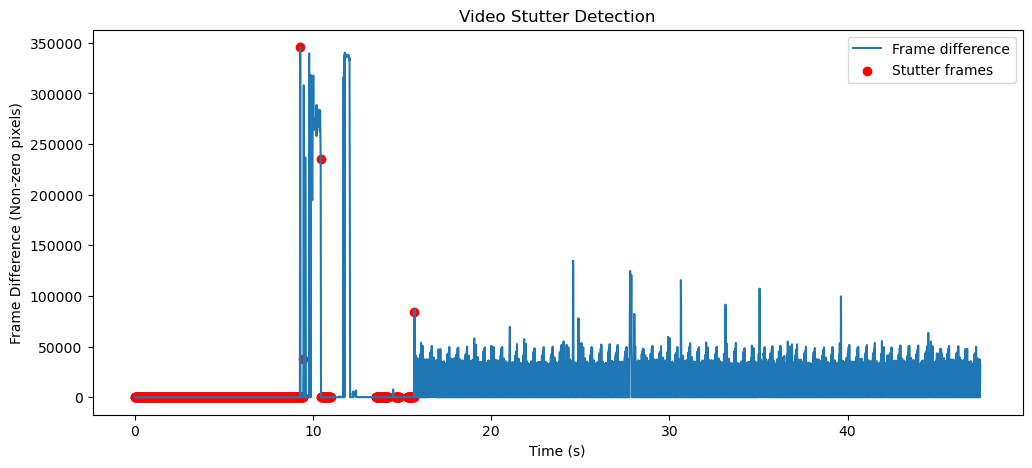

In [13]:
# -----------------------------------------------
# 実行例
# -----------------------------------------------

# Python では、この書き方をすると
# 「このファイルを直接実行したときだけ、以下の処理を動かす」という意味
if __name__ == "__main__":  
    # list_video_devices 関数を呼んで、PCに接続されているカメラを探す
    # 戻り値 devices は [(0, 'Camera 0'), (1, 'Camera 1'), ...] の形式
    devices = list_video_devices()
    if not devices:
        print("利用可能なカメラが見つかりませんでした")
    else:
        # launch_gui 関数で、ユーザーにカメラを選ばせる
        # 戻り値 selected_device は選択されたカメラのデバイス番号
        selected_device = launch_gui(devices)
        if selected_device is not None:
            print(f"選択されたデバイス番号: {selected_device}")
        else:
            print("カメラが選択されませんでした（GUIを閉じました）")

    # 「カメラが選ばれたときだけキャプチャを開始する」 という安全策
    if selected_device is not None: 
        frame_count, output_folder, actual_fps, stutter_frames = start_capture_and_detect(
            device_number=selected_device,  # GUIで選ばれたデバイスを使用
            capture_fps=60,                # キャプチャFPS
            display_fps=10,                # プレビュー表示FPS
            min_time_diff=0.1,             # カクつき最小検知時間
            stop_no_diff_sec=300,          # 変化なしで自動停止する秒数
            threshold_method='std',        # 自動閾値計算方法
            k=2.0                          # 標準偏差倍率
        )

        # 保存済み PNG からフレームを読み込む
        temp_folder = os.path.join(os.path.expanduser("~"), "Desktop", "temp_frames")
        frame_files = sorted([f for f in os.listdir(temp_folder) if f.endswith('.png')])
        frames = [cv2.imread(os.path.join(temp_folder, f)) for f in frame_files]

        # stutter_frames は output_folder 内の PNG からフレーム番号を取得
        output_folder = os.path.join(os.path.expanduser("~"), "Desktop", "stutter_frames")
        stutter_frames = []
        for f in os.listdir(output_folder):
            if f.startswith('stutter_') and f.endswith('.png'):
                # ファイル名から最後の数値部分を抽出してフレーム番号として記録
                match = re.search(r'(\d+)\.png$', f)
                if match:
                    stutter_frames.append(int(match.group(1)))

        # フレーム番号を昇順にソート
        stutter_frames = sorted(stutter_frames)

        # 可視化関数で時間軸と差分値をグラフ表示
        plot_stutter(frames, stutter_frames, fps=60)
